In [3]:
import os
import json
import pandas as pd
import numpy as np 
np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from scipy import stats

# Unzip NASLib/run/results/xgb_correlation.zip before running the code

In [5]:
BENCHMARKS = {
#     'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED=0
END_SEED=4

def get_all_files(root_folder='../run/model_only_zc', filename='scores.json'):
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                #print(os.path.join(root, file))
                all_files.append(os.path.join(root, file))

    return all_files

def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        file_components = file.split('/')
        # print(file_components)
        predictor_type, search_space, dataset, feature_size, train_size, seed = file_components[-7], file_components[-6], file_components[-5], file_components[-4], file_components[-3], file_components[-2]
        # ['..', 'run', 'model_only_zc', 'ridge', 'nasbench201', 'cifar10', 'k_3', 'train_size5', 'seed_9000', 'scores.json']
        with open(file, 'r') as f:
            info = json.load(f)

        config, scores = info[0], info[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'train_size': train_size,
            'feature_size': feature_size,
            'predictor_type': predictor_type,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        zc_names = config['zc_names']
        feature_importances = scores['zc_feature_importances']
        for zc_name in zc_names:
            record[f'{zc_name}_feat_imp'] = feature_importances[zc_name]

        data.append(record)

    return data

def plot_heatmap(df, figsize=(18, 6), rotation=0, title=''):
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    heatmap = sns.heatmap(df, annot=True, cmap='viridis')
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=rotation)
    
    
def plot_heatmap_for_benchmark(df, search_space, dataset, corr_type):
    _df = df[(df['search_space'] == search_space) & (df['dataset'] == dataset)][['train_size', 'seed', corr_type]]

#     print('BEFORE PIVOT')
#     print(_df)
#     print('___')
    
    pivot_df = _df.pivot_table(corr_type, 'seed', 'train_size')
    pivot_df.columns = pivot_df.columns.astype(int)
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)
    
    print('PIVOT TABLE')
    print(pivot_df)
    print('___')

    plot_heatmap(pivot_df.corr(), title=f'Correlation between rank correlations for {search_space}-{dataset}')

def compute_correlation(df, predictors):
    corr = np.zeros((len(predictors), len(predictors)))
    for i in range(len(predictors)):
        for j in range(len(predictors)):
            zc_1 = predictors[i]
            zc_2 = predictors[j]

            preds_1 = np.array(df[df['train_size'] == zc_1]['preds'].to_list()[0])
            preds_2 = np.array(df[df['train_size'] == zc_2]['preds'].to_list()[0])
            coeff = np.corrcoef(preds_1, preds_2)[0, 1]
                
            #print(preds_1.shape, preds_2.shape, coeff)
            corr[i, j] = coeff

    return corr

def plot_correlation_between_zcs(df, search_space, dataset):
    all_corrs = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
    
        df_ = df[(df['search_space'] == search_space) & (df['seed'] == seed) & (df['dataset'] == dataset)]
        train_sizes = tuple(df_['train_size'].to_list()) # List of predictor names

        all_corrs.append(compute_correlation(df_, train_sizes))

    corr = np.mean(np.array(all_corrs), axis=0)
    corr_df = pd.DataFrame(corr)

    train_sizes_map = {i: train_sizes[i] for i in range(len(train_sizes))}
    corr_df = corr_df.rename(columns=train_sizes_map, index=train_sizes_map)
    plot_heatmap(corr_df, title=f'ZC Correlation for {search_space}-{dataset}')
    
def show_seeds(df, search_space):
    return df[df['search_space'] == search_space].groupby(['search_space', 'dataset', 'train_size'])['seed'].agg(['unique'])

def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_search_space_train_size_df(df, metric, benchmarks):
    pred_scores = df.groupby(['search_space', 'dataset', 'train_size'])[metric].mean()
    
    series = []
    for searchspace, datasets in benchmarks.items():
        for dataset in datasets:
            if searchspace in pred_scores and dataset in pred_scores[searchspace]:
                series.append(pred_scores[searchspace][dataset].rename(f'{LABELS[searchspace]}-{LABELS[dataset]}'))

    # Concatenate all the series from left to right to get the dataframe
    # with datasets as the columns and 
    idf = series[0].to_frame()

    for idx, s in enumerate(series):
        if idx == 0:
            continue

        idf = idf.merge(s, left_index=True, right_index=True)

    return idf

# with open('../run/correlation/nasbench201/cifar10/jacov/9001/scores.json', 'r') as f:
#     data = json.load(f)


In [6]:
files = get_all_files()

In [7]:
df = make_df(files)
print(df)

    search_space  dataset train_size feature_size predictor_type  seed  \
0    nasbench201  cifar10          5           13          trees  9000   
1    nasbench201  cifar10          5           13          trees  9001   
2    nasbench201  cifar10          5           13          trees  9002   
3    nasbench201  cifar10          5           13          trees  9003   
4    nasbench201  cifar10          5           13          trees  9004   
..           ...      ...        ...          ...            ...   ...   
235  nasbench201  cifar10       1000           13          bayes  9005   
236  nasbench201  cifar10       1000           13          bayes  9006   
237  nasbench201  cifar10       1000           13          bayes  9007   
238  nasbench201  cifar10       1000           13          bayes  9008   
239  nasbench201  cifar10       1000           13          bayes  9009   

     kendalltau   pearson  spearman  \
0      0.466020  0.370487  0.650486   
1      0.661668  0.946305  0.8487

In [26]:
def get_metrics(df, search_space, dataset, train_size, metric):
    print(search_space, train_size, dataset)
    print(sum((df['search_space'] == search_space)), sum((df['train_size'] == str(train_size))), sum((df['dataset'] == dataset)))
    df_ = df[(df['search_space'] == search_space) & (df['train_size'] == str(train_size)) & (df['dataset'] == dataset)]

    # print(df_)
    # print(df_[metric])
    # print(type())
    print(df_[metric])
    return df_[metric]  # removed tolist() because I don't have multiple predictor sizes)

def get_metrics_as_np_arrays(df, search_space, dataset, train_sizes, metric):
    results = []

    for train_size in train_sizes:
        res = get_metrics(df, search_space, dataset, train_size, metric)
        if len(res) > 0:
            results.append(res)
    print(results)
    print(len(results))
    print([len(results[i]) for i in range(len(results))])
    results = np.array(results)
    means = np.mean(results, axis=1)
    stds = np.std(results, axis=1)
    
    return means, stds


def plot_line_chart(x_labels, means, stds, color, title='', ylabel='', use_same_fig=False, legend=None):
    if not use_same_fig:
        figsize=(16, 8)
        plt.figure(figsize=figsize, dpi=200)
        plt.title(title, fontsize=20)
    plt.plot(x_labels, means, color=color, label=legend)
    plt.fill_between(x_labels, means + stds, means - stds, color=color, alpha=0.2)
    plt.xscale('log', base=10)
    plt.xlabel('Train size')
    plt.ylabel(ylabel)
    # if legend:
    #     plt.legend(legend)

def plot_train_sizes_vs_metric(df, search_space, dataset, train_sizes, metric, color='gray'):
    means, stds = get_metrics_as_np_arrays(df, search_space, dataset, train_sizes, metric)
    print(means, stds)
    plot_line_chart(train_sizes, means, stds, color, title=f'{search_space}-{dataset}', ylabel=f'{metric} coefficient')

def plot_feature_train_sizes_vs_metric(df, search_space, dataset, train_sizes, feature_sizes, metric, colors=('red', 'blue', 'gray', 'black')):
    for i, feature_size in enumerate(feature_sizes):
        sub_df = df[(df['feature_size'] == str(feature_size))]
        means, stds = get_metrics_as_np_arrays(sub_df, search_space, dataset, train_sizes, metric)
        print(feature_size, 'MEANS: ', means)
        plot_line_chart(train_sizes, means, stds, colors[i], title=f'{search_space}-{dataset}', ylabel=f'{metric} coefficient', use_same_fig=(i!=0), legend='features='+feature_size)
    plt.legend(loc="lower right")

# def get_metrics_by_idx(df, search_space, dataset, idx, metric):
#     df_ = df[(df['search_space'] == search_space) & idx & (df['dataset'] == dataset)]
#     return df_[metric].tolist()  # removed tolist() because I don't have multiple predictor sizes)

# def get_filtered_metrics_as_np_arrays(df, search_space, dataset, idxs, metric):
#     results = []

#     for idx in idxs:
#         res = get_metrics_by_idx(df, search_space, dataset, idx, metric)
#         if len(res) > 0:
#             results.append(res)
#     print(results)
#     print(len(results))
#     print([len(results[i]) for i in range(len(results))])
#     results = np.array(results)
#     means = np.mean(results, axis=1)
#     stds = np.std(results, axis=1)
    
#     return means, stds


# def plotvs_metric(df, search_space, dataset, idxs, metric, color='gray'):
#     means, stds = get_metrics_as_np_arrays(df, search_space, dataset, idxs, metric)
#     print(means, stds)
#     plot_line_chart(train_sizes, means, stds, color, title=f'{search_space}-{dataset}', ylabel=f'{metric} coefficient')

def plot_predictors_vs_metric(df, search_space, dataset, train_sizes, predictors, metric, colors=('red', 'blue', 'gray', 'black')):
    for i, predictor in enumerate(predictors):
        sub_df = df[(df['predictor_type'] == predictor)]
        means, stds = get_metrics_as_np_arrays(sub_df, search_space, dataset, train_sizes, metric)
        print(predictor, 'MEANS: ', means)
        plot_line_chart(train_sizes, means, stds, colors[i], title=f'{search_space}-{dataset}', ylabel=f'{metric} coefficient', use_same_fig=(i!=0), legend='pred='+predictor)
    plt.legend(loc="lower right")

nasbench201 5 cifar10
80 10 80
80    0.740651
81    0.748359
82    0.672445
83    0.409352
84    0.684539
85    0.532280
86    0.126056
87    0.639443
88    0.504496
89    0.755527
Name: spearman, dtype: float64
nasbench201 8 cifar10
80 10 80
90    0.736534
91    0.204675
92    0.584755
93    0.745332
94    0.245811
95    0.652541
96    0.741763
97   -0.171859
98   -0.106860
99    0.411578
Name: spearman, dtype: float64
nasbench201 14 cifar10
80 10 80
100    0.443084
101    0.911127
102    0.469661
103    0.466778
104    0.498731
105    0.779656
106    0.742445
107    0.137342
108    0.411543
109    0.594986
Name: spearman, dtype: float64
nasbench201 24 cifar10
80 10 80
110    0.687682
111    0.898416
112    0.757439
113    0.528505
114    0.598864
115    0.475259
116    0.831966
117    0.629525
118    0.180388
119    0.652489
Name: spearman, dtype: float64
nasbench201 42 cifar10
80 10 80
120    0.854291
121    0.862474
122    0.850120
123    0.886301
124    0.643532
125    0.759176
12

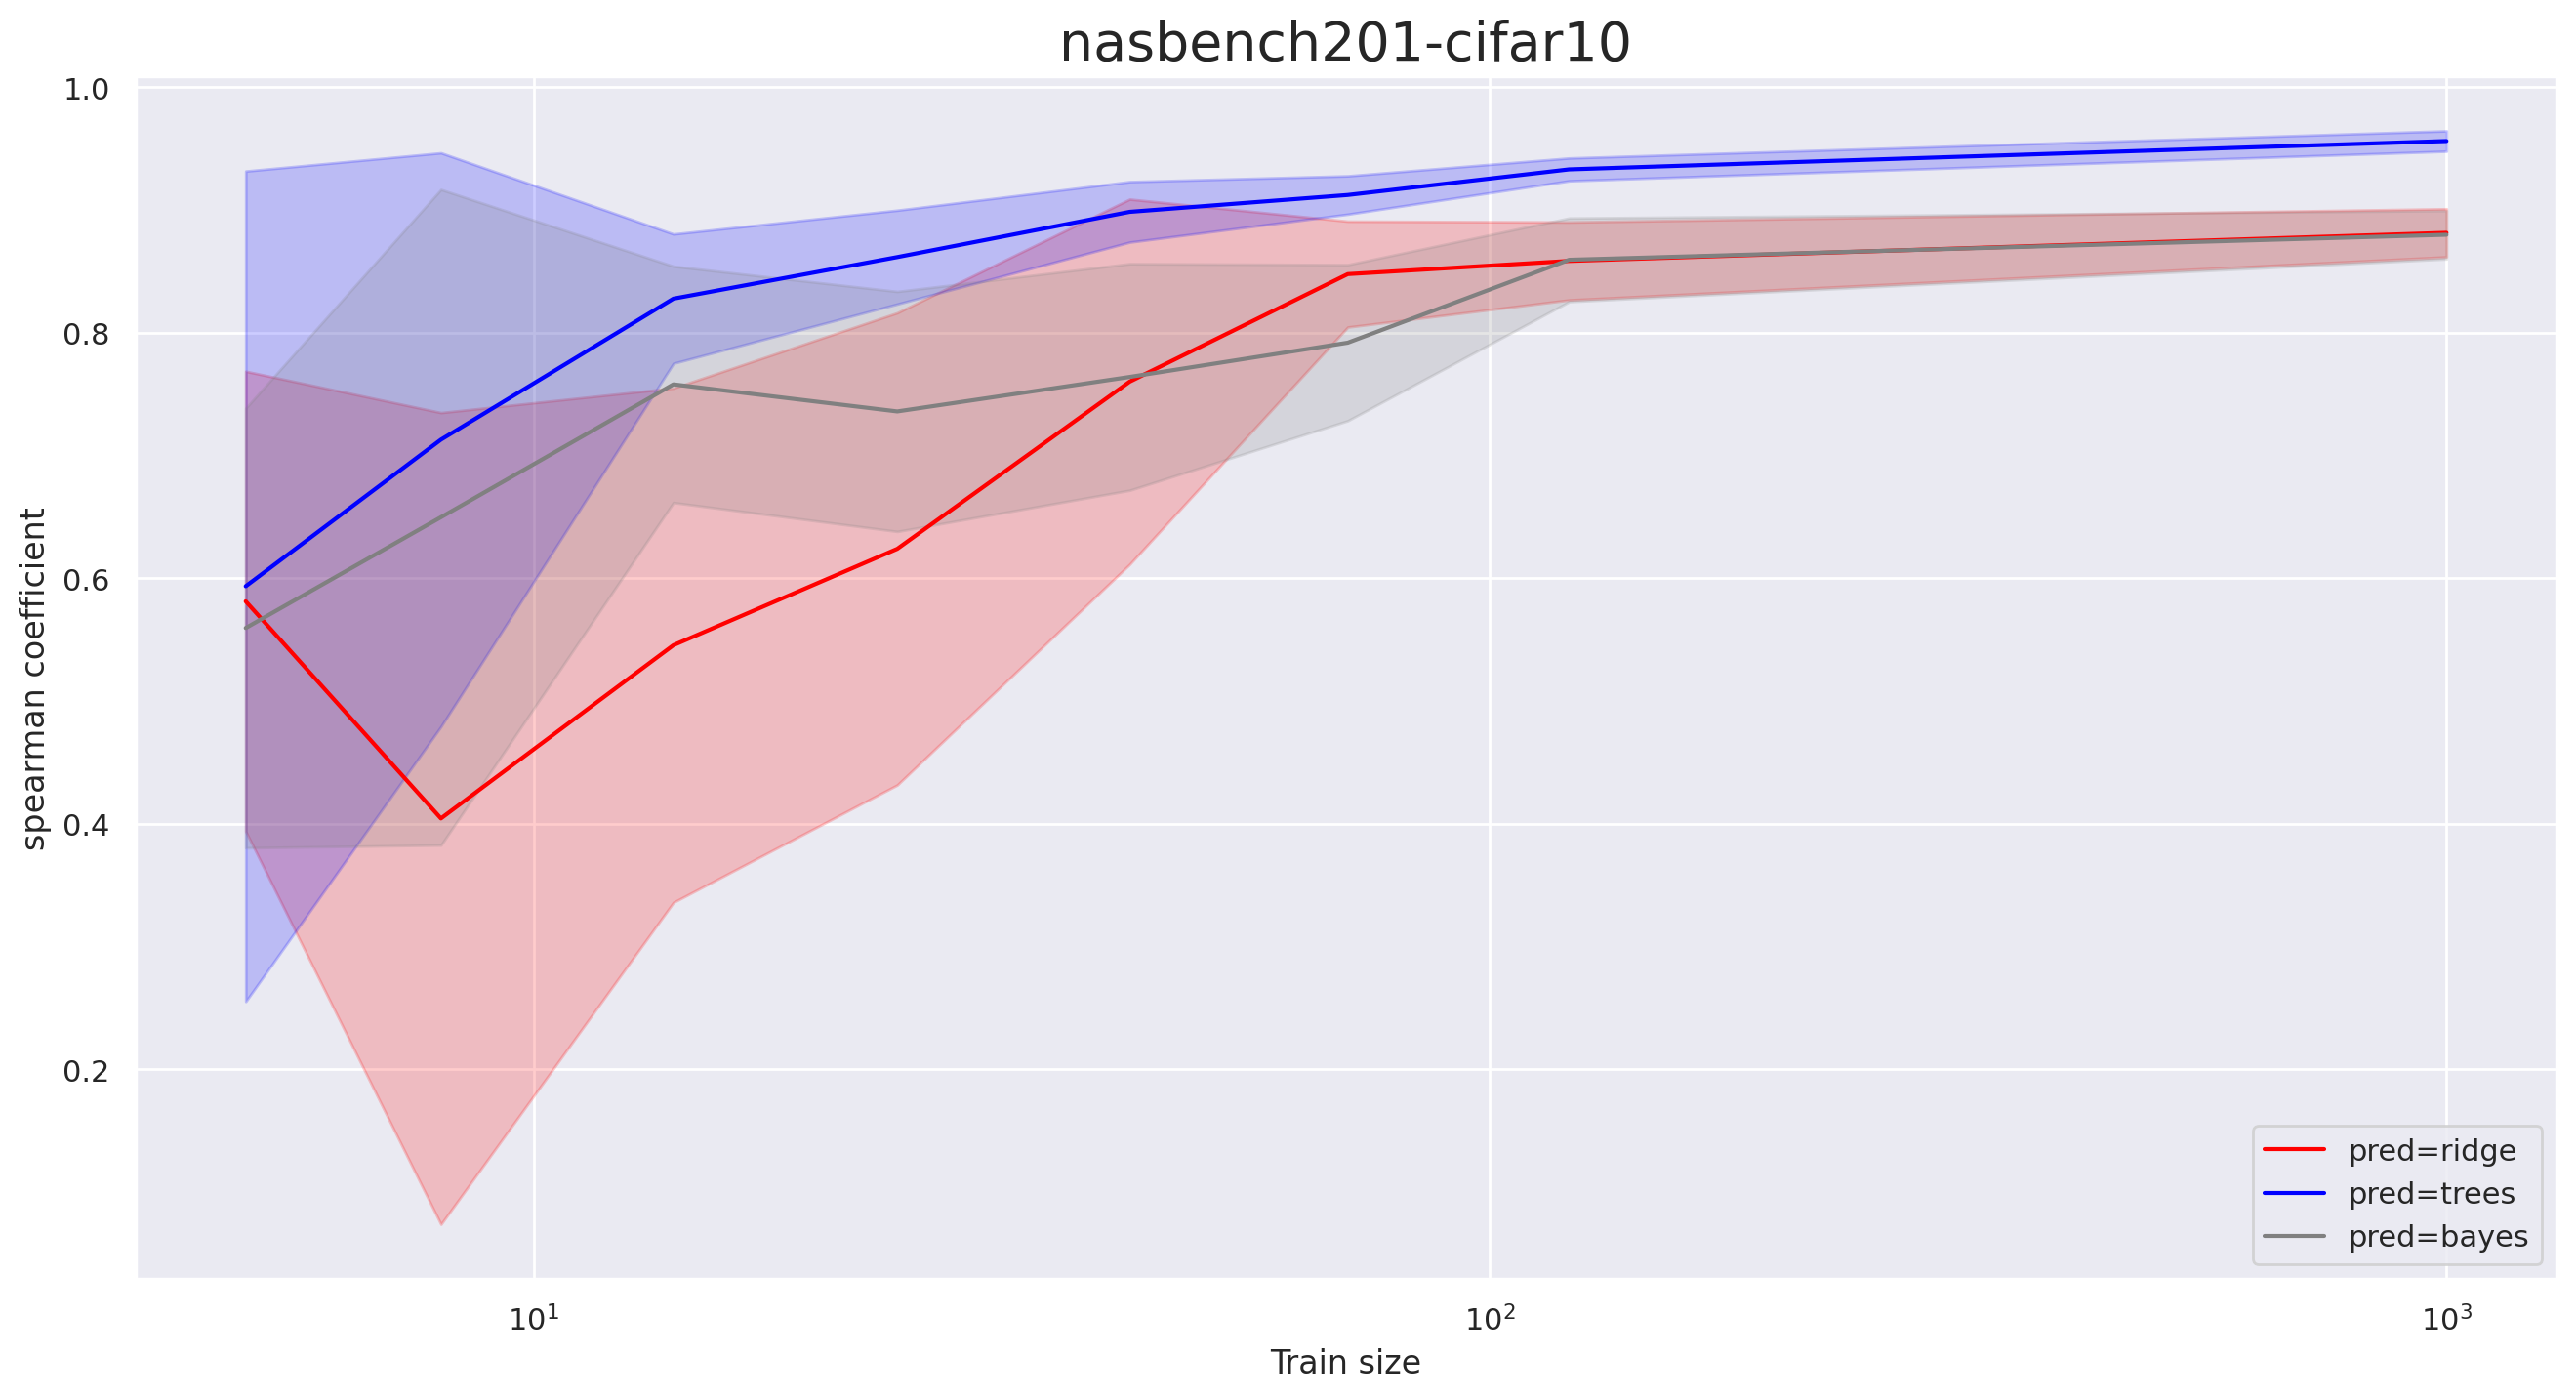

In [31]:
# train_sizes = [10, 16, 27, 46, 77, 129, 215, 359, 599]
# train_sizes = [10, 15, 23, 36, 56, 87, 135, 209, 323, 500]
# train_sizes = [400]
train_sizes = (5, 8, 14, 24, 42, 71, 121, 1000) #, 205, 347, 589, 1000)

#df = make_df(files)
# sp = get_metrics(df, 'nasbench201', 'cifar10', 5, 'spearman')


predictors=['ridge', 'trees', 'bayes']
plot_predictors_vs_metric(df, 'nasbench201', 'cifar10', train_sizes, predictors, 'spearman')



In [32]:
def get_mean_grouped_by(df, search_space, dataset, train_size):
    df_ = df[(df['search_space'] == search_space) & (df['train_size'] == train_size) & (df['dataset'] == dataset)]
    return df_.groupby(['search_space', 'dataset', 'train_size'], as_index=False).mean()

def get_averaged_df(df, search_space, train_sizes):
    dfs = []

    for dataset in BENCHMARKS[search_space]:
        for train_size in train_sizes:
            dfs.append(get_mean_grouped_by(df, search_space, dataset, str(train_size)))
    
    return pd.concat(dfs)

# def get_averaged_feature_df(df, search_space, train_sizes, feature_size):
#     dfs = []

#     for dataset in BENCHMARKS[search_space]:
#         for train_size in train_sizes:
#             dfs.append(get_mean_grouped_by(df, search_space, dataset, str(train_size)))
    
#     return pd.concat(dfs)

def get_feature_importance_df(df, search_space, train_size):
    avg_df = get_averaged_df(df, search_space, train_sizes)
    feat_imp_cols = [c for c in avg_df.columns if c.endswith('_feat_imp')]
    avg_df = avg_df[avg_df['train_size'] == train_size].set_index('dataset')[feat_imp_cols]
    return avg_df

def plot_feature_importance_heatmap(df, search_space, train_size):
    avg_df = get_feature_importance_df(df, search_space, str(train_size))
    
    if search_space == 'transbench101_micro' or search_space == 'transbench101_macro':
        avg_df = avg_df.drop(columns=['epe_nas_feat_imp', 'synflow_feat_imp'])
    plot_heatmap(avg_df, rotation=45, title=f'{search_space}. Train size: {train_size}')

In [33]:
avg_df_nb201 = get_averaged_df(df, 'nasbench201', train_sizes)

avg_over_features = df[(df['search_space'] == 'nasbench201') & (df['train_size'] == 71) & (df['dataset']=='cifar10')].mean()
avg_over_features


# avg_df_nb301 = get_averaged_df(df, 'nasbench301', train_sizes)
# avg_df_tnb_micro = get_averaged_df(df, 'transbench101_micro', train_sizes)
# avg_df_tnb_macro = get_averaged_df(df, 'transbench101_macro', train_sizes)
# avg_df = pd.concat([avg_df_nb201, avg_df_nb301, avg_df_tnb_micro, avg_df_tnb_macro], axis=0)
# avg_df

search_space          NaN
dataset               NaN
train_size            NaN
feature_size          NaN
predictor_type        NaN
seed                  NaN
kendalltau            NaN
pearson               NaN
spearman              NaN
preds                 NaN
ground_truth          NaN
synflow_feat_imp      NaN
plain_feat_imp        NaN
l2_norm_feat_imp      NaN
flops_feat_imp        NaN
snip_feat_imp         NaN
grad_norm_feat_imp    NaN
nwot_feat_imp         NaN
zen_feat_imp          NaN
fisher_feat_imp       NaN
jacov_feat_imp        NaN
epe_nas_feat_imp      NaN
params_feat_imp       NaN
grasp_feat_imp        NaN
dtype: object

In [34]:
feat_imp_cols = [c for c in avg_df.columns if c.endswith('_feat_imp')]
feat_imp_cols

NameError: name 'avg_df' is not defined

In [ ]:
df = make_df(files)

ValueError: zero-size array to reduction operation fmin which has no identity

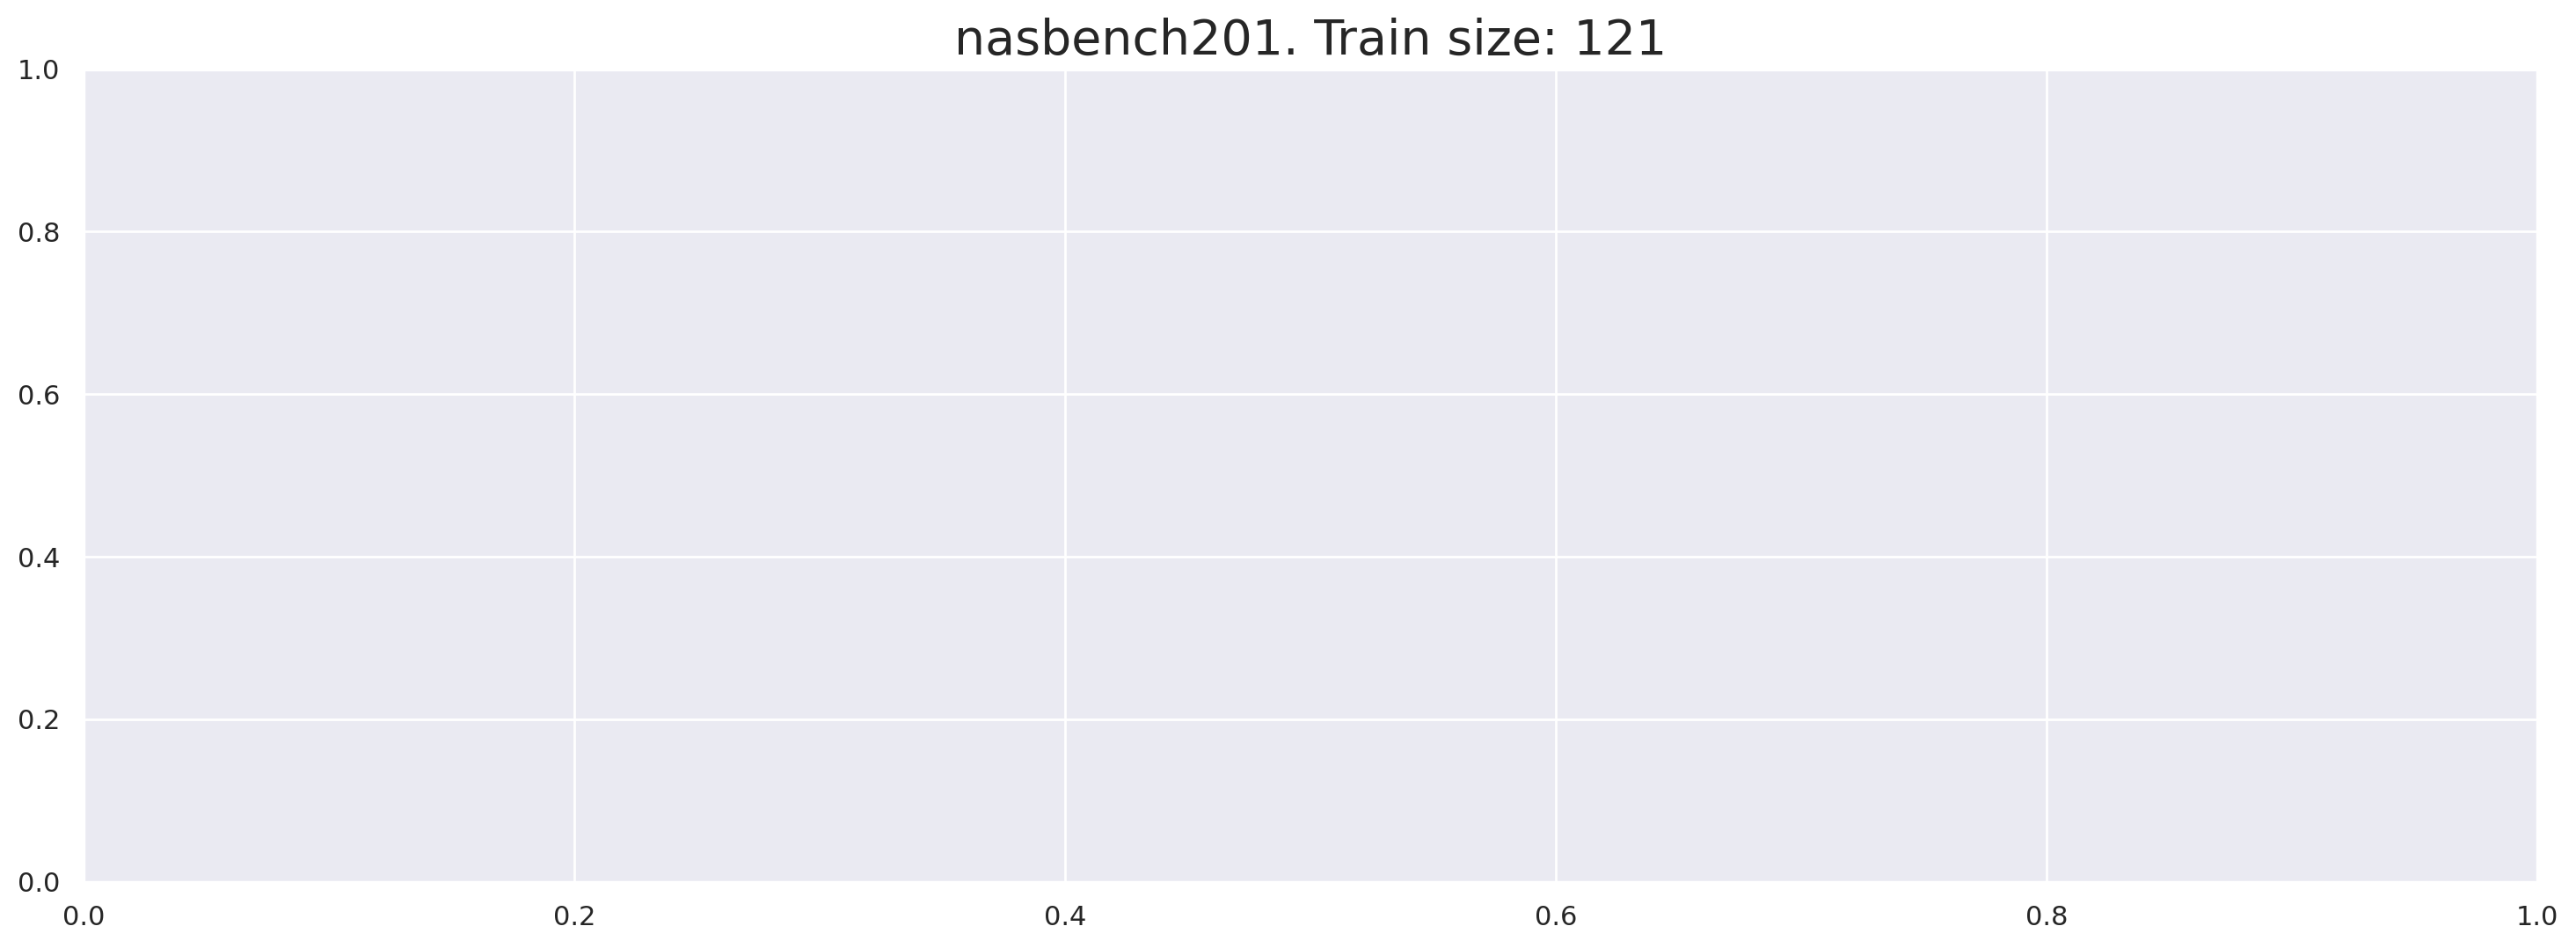

In [ ]:
search_space='nasbench201'
train_size=121
plot_feature_importance_heatmap(df, search_space, train_size=train_size)

ValueError: zero-size array to reduction operation fmin which has no identity

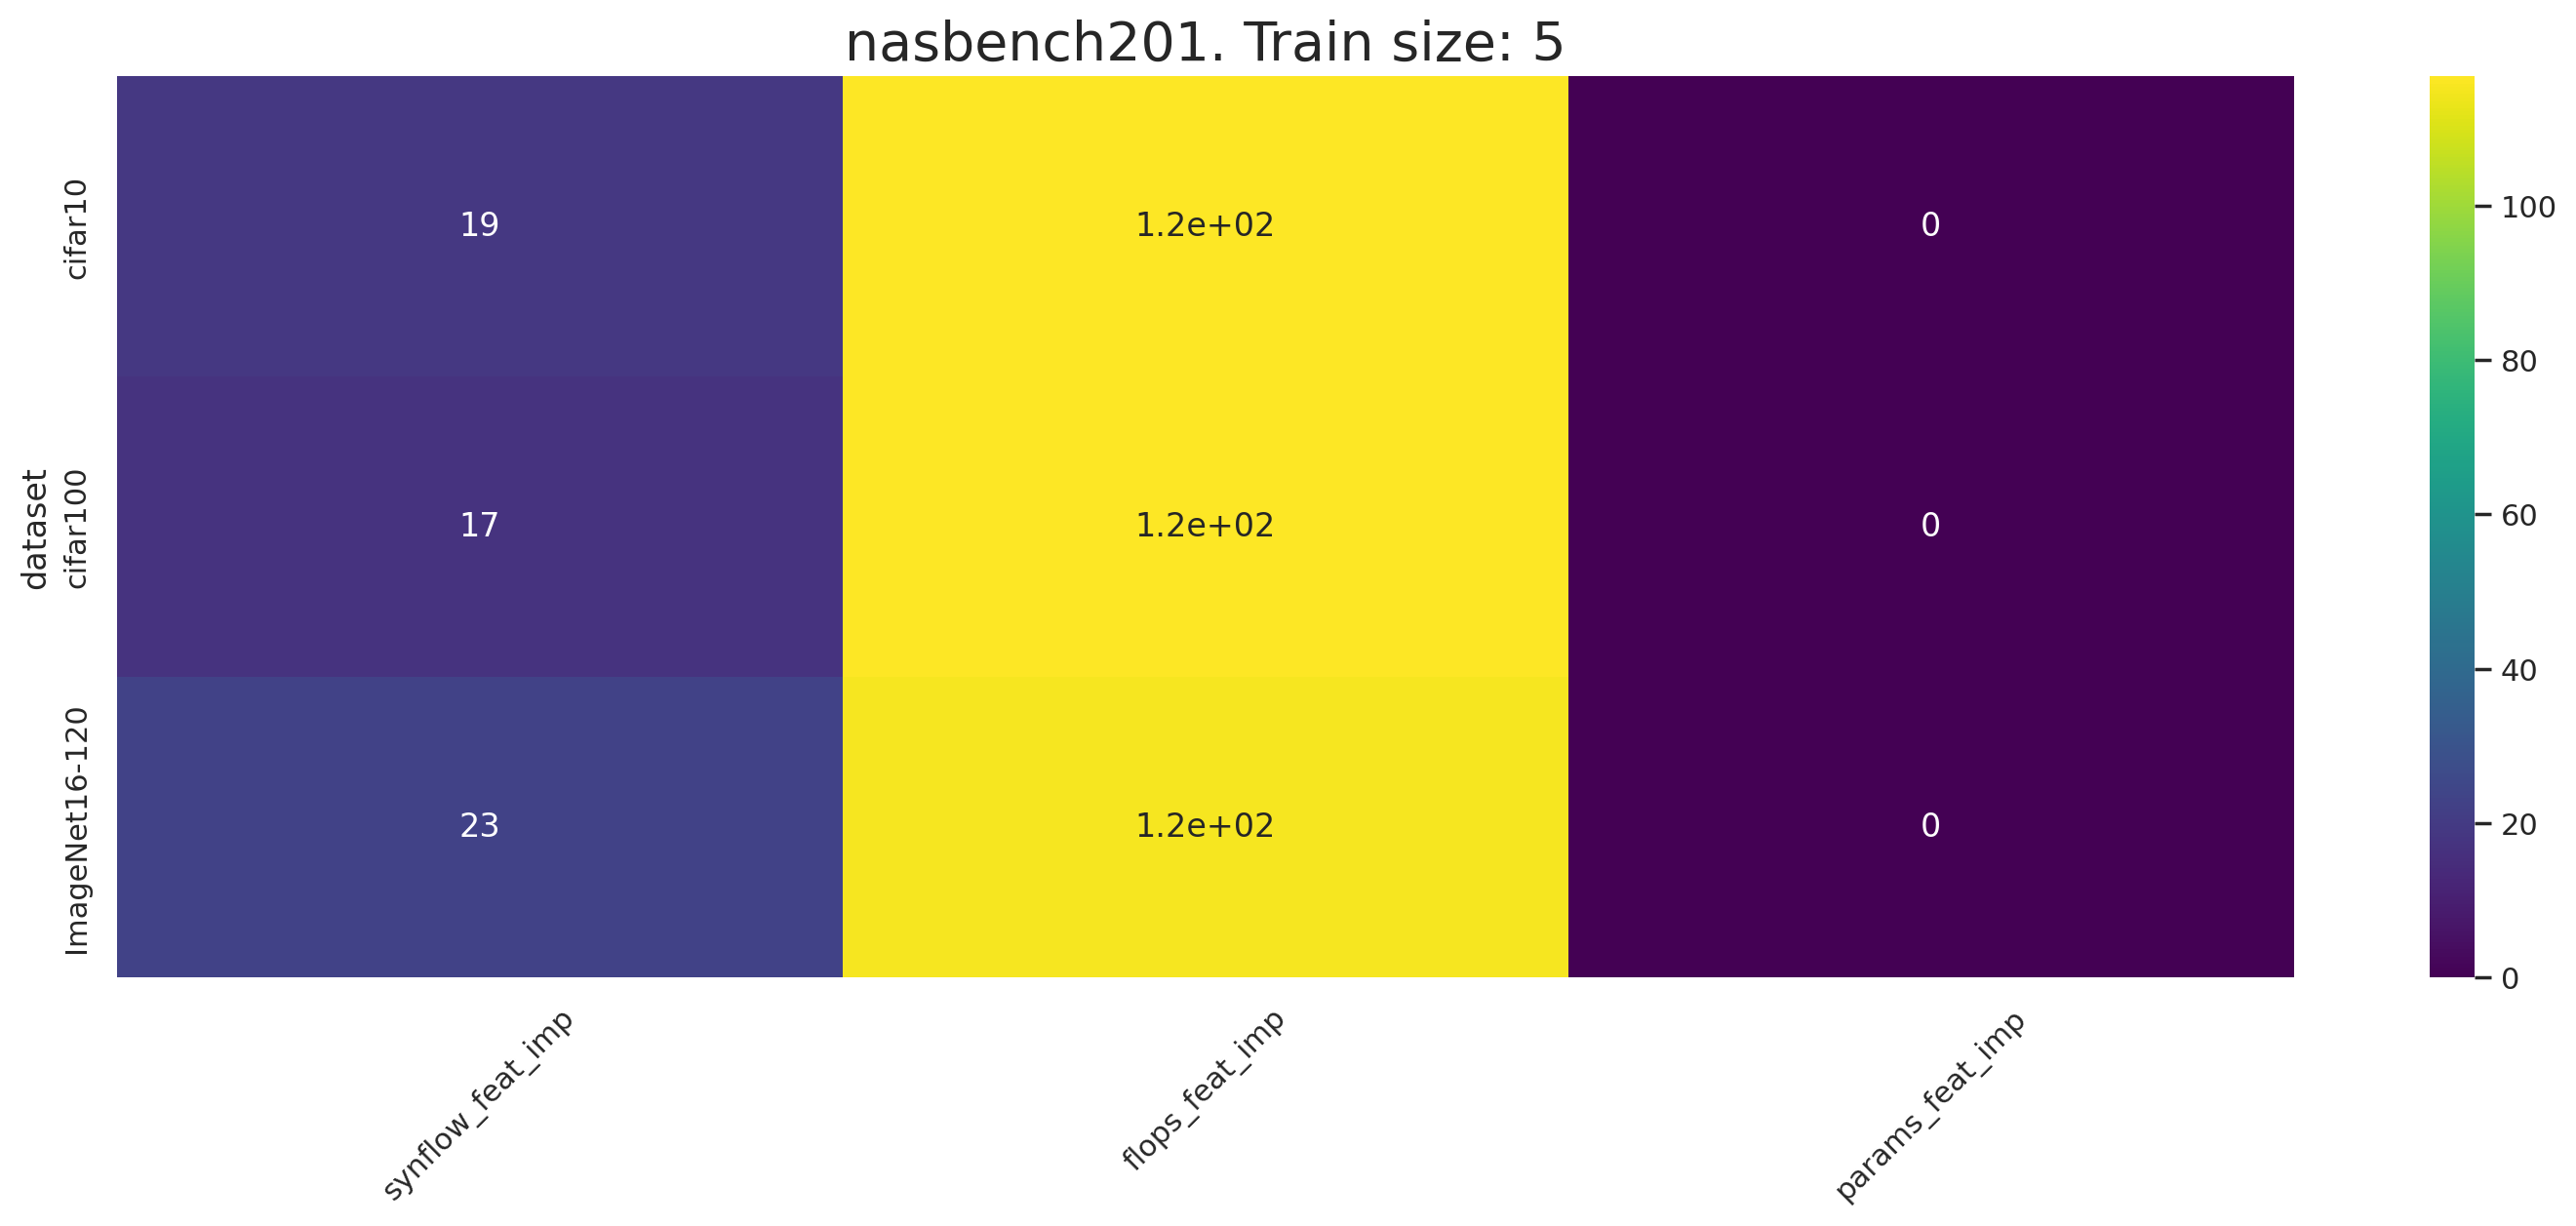

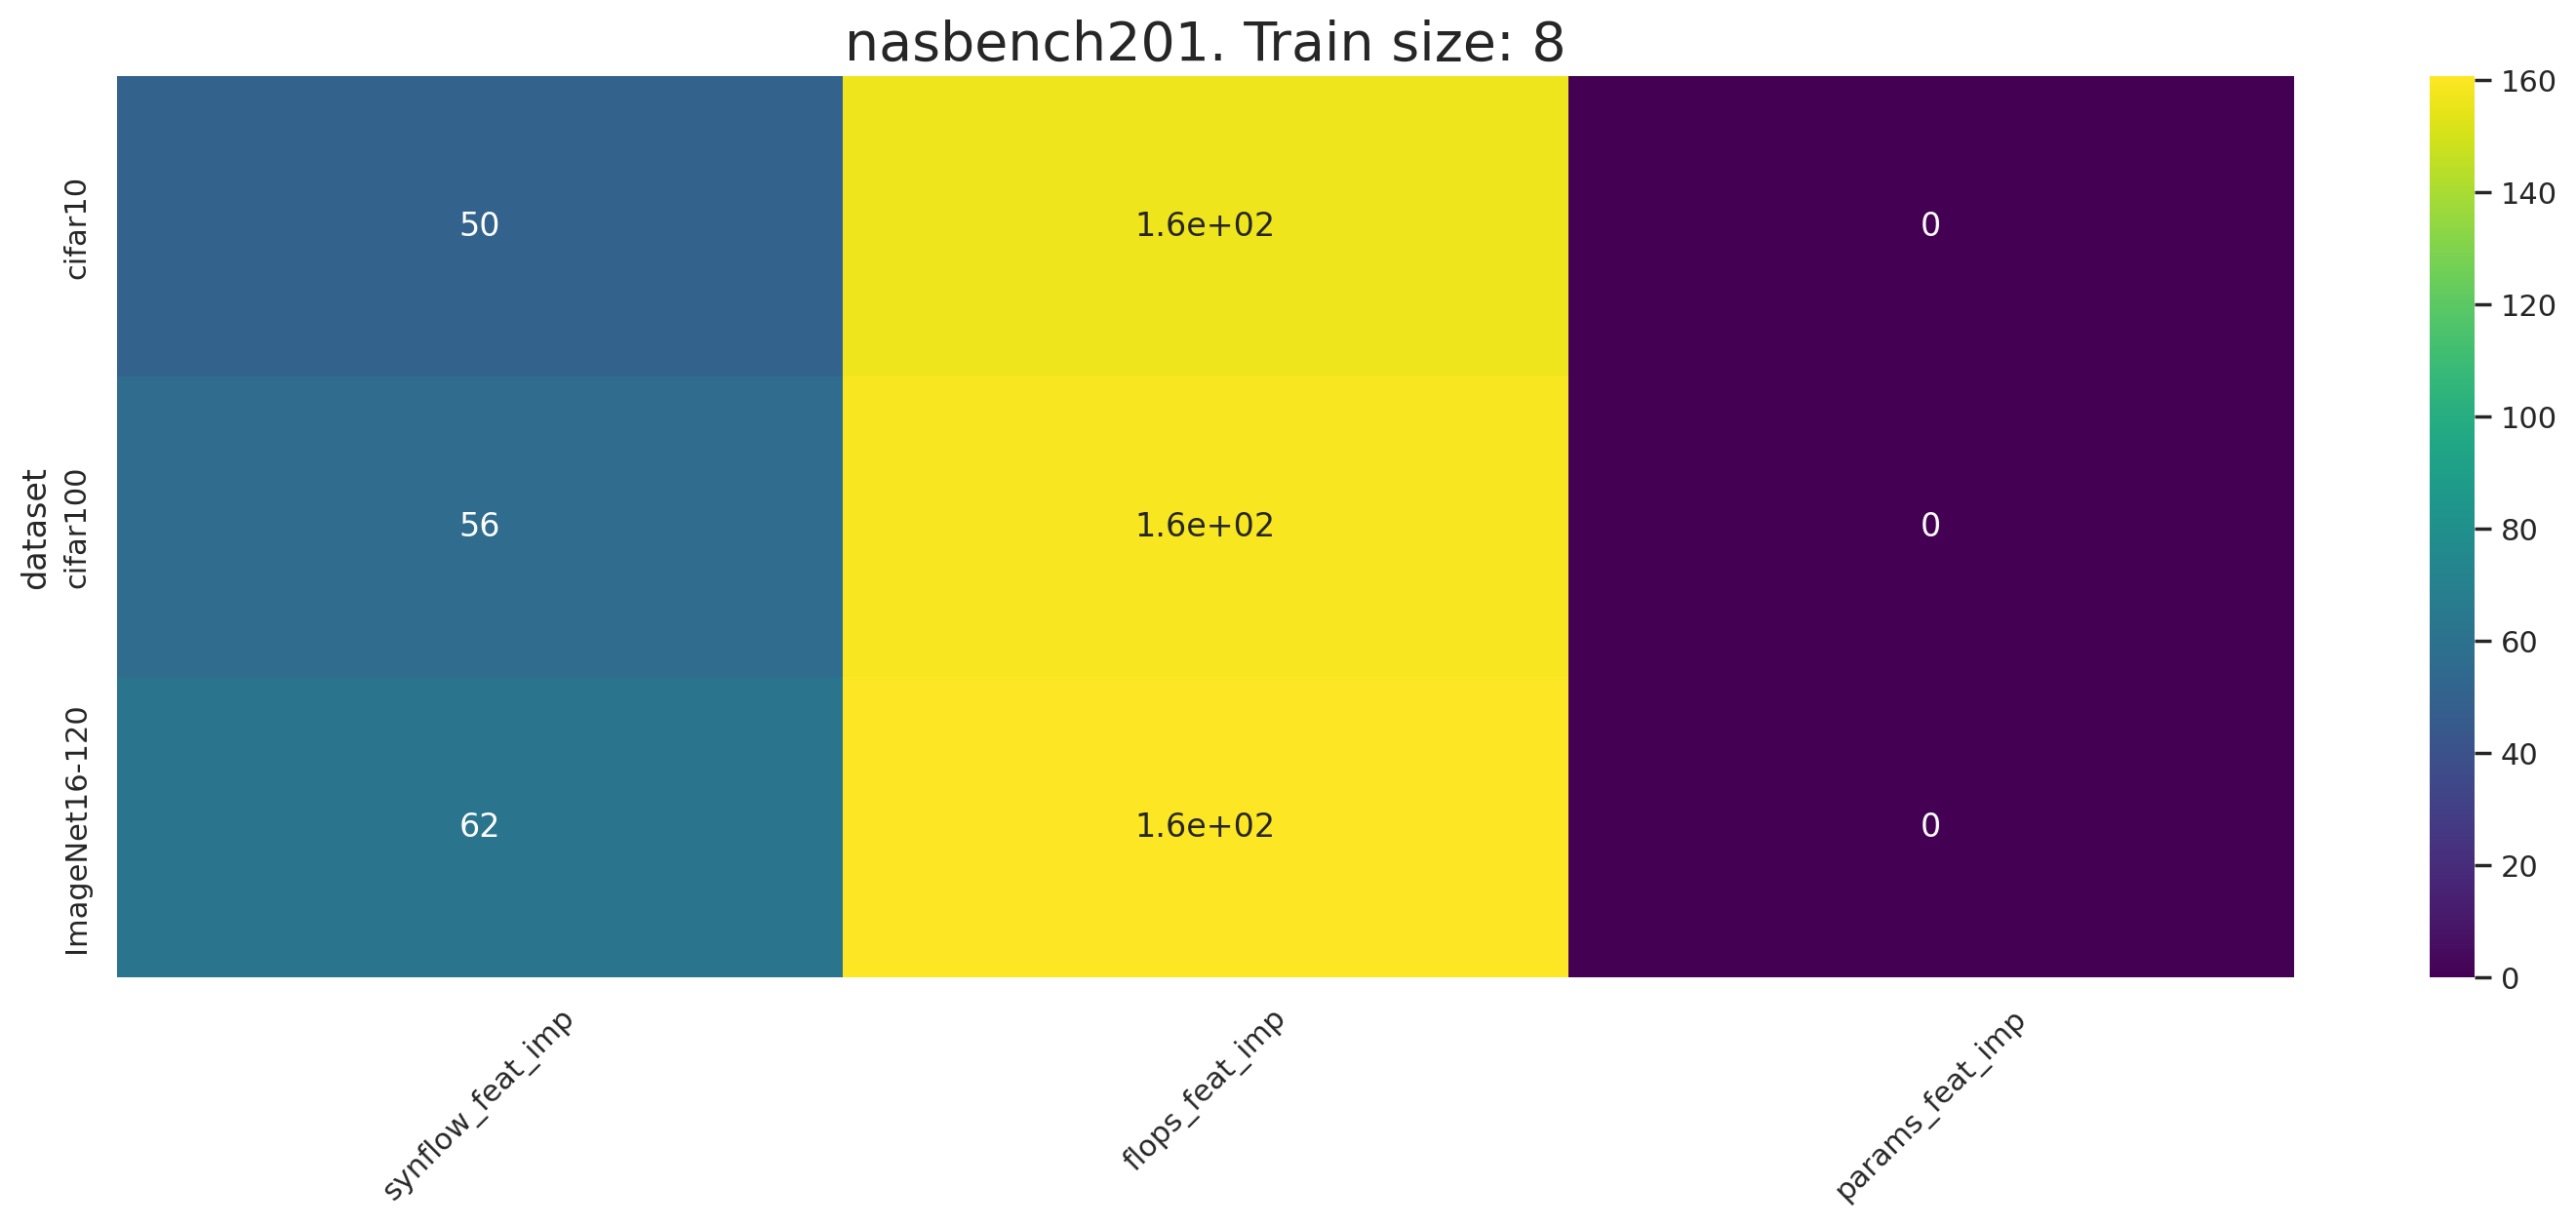

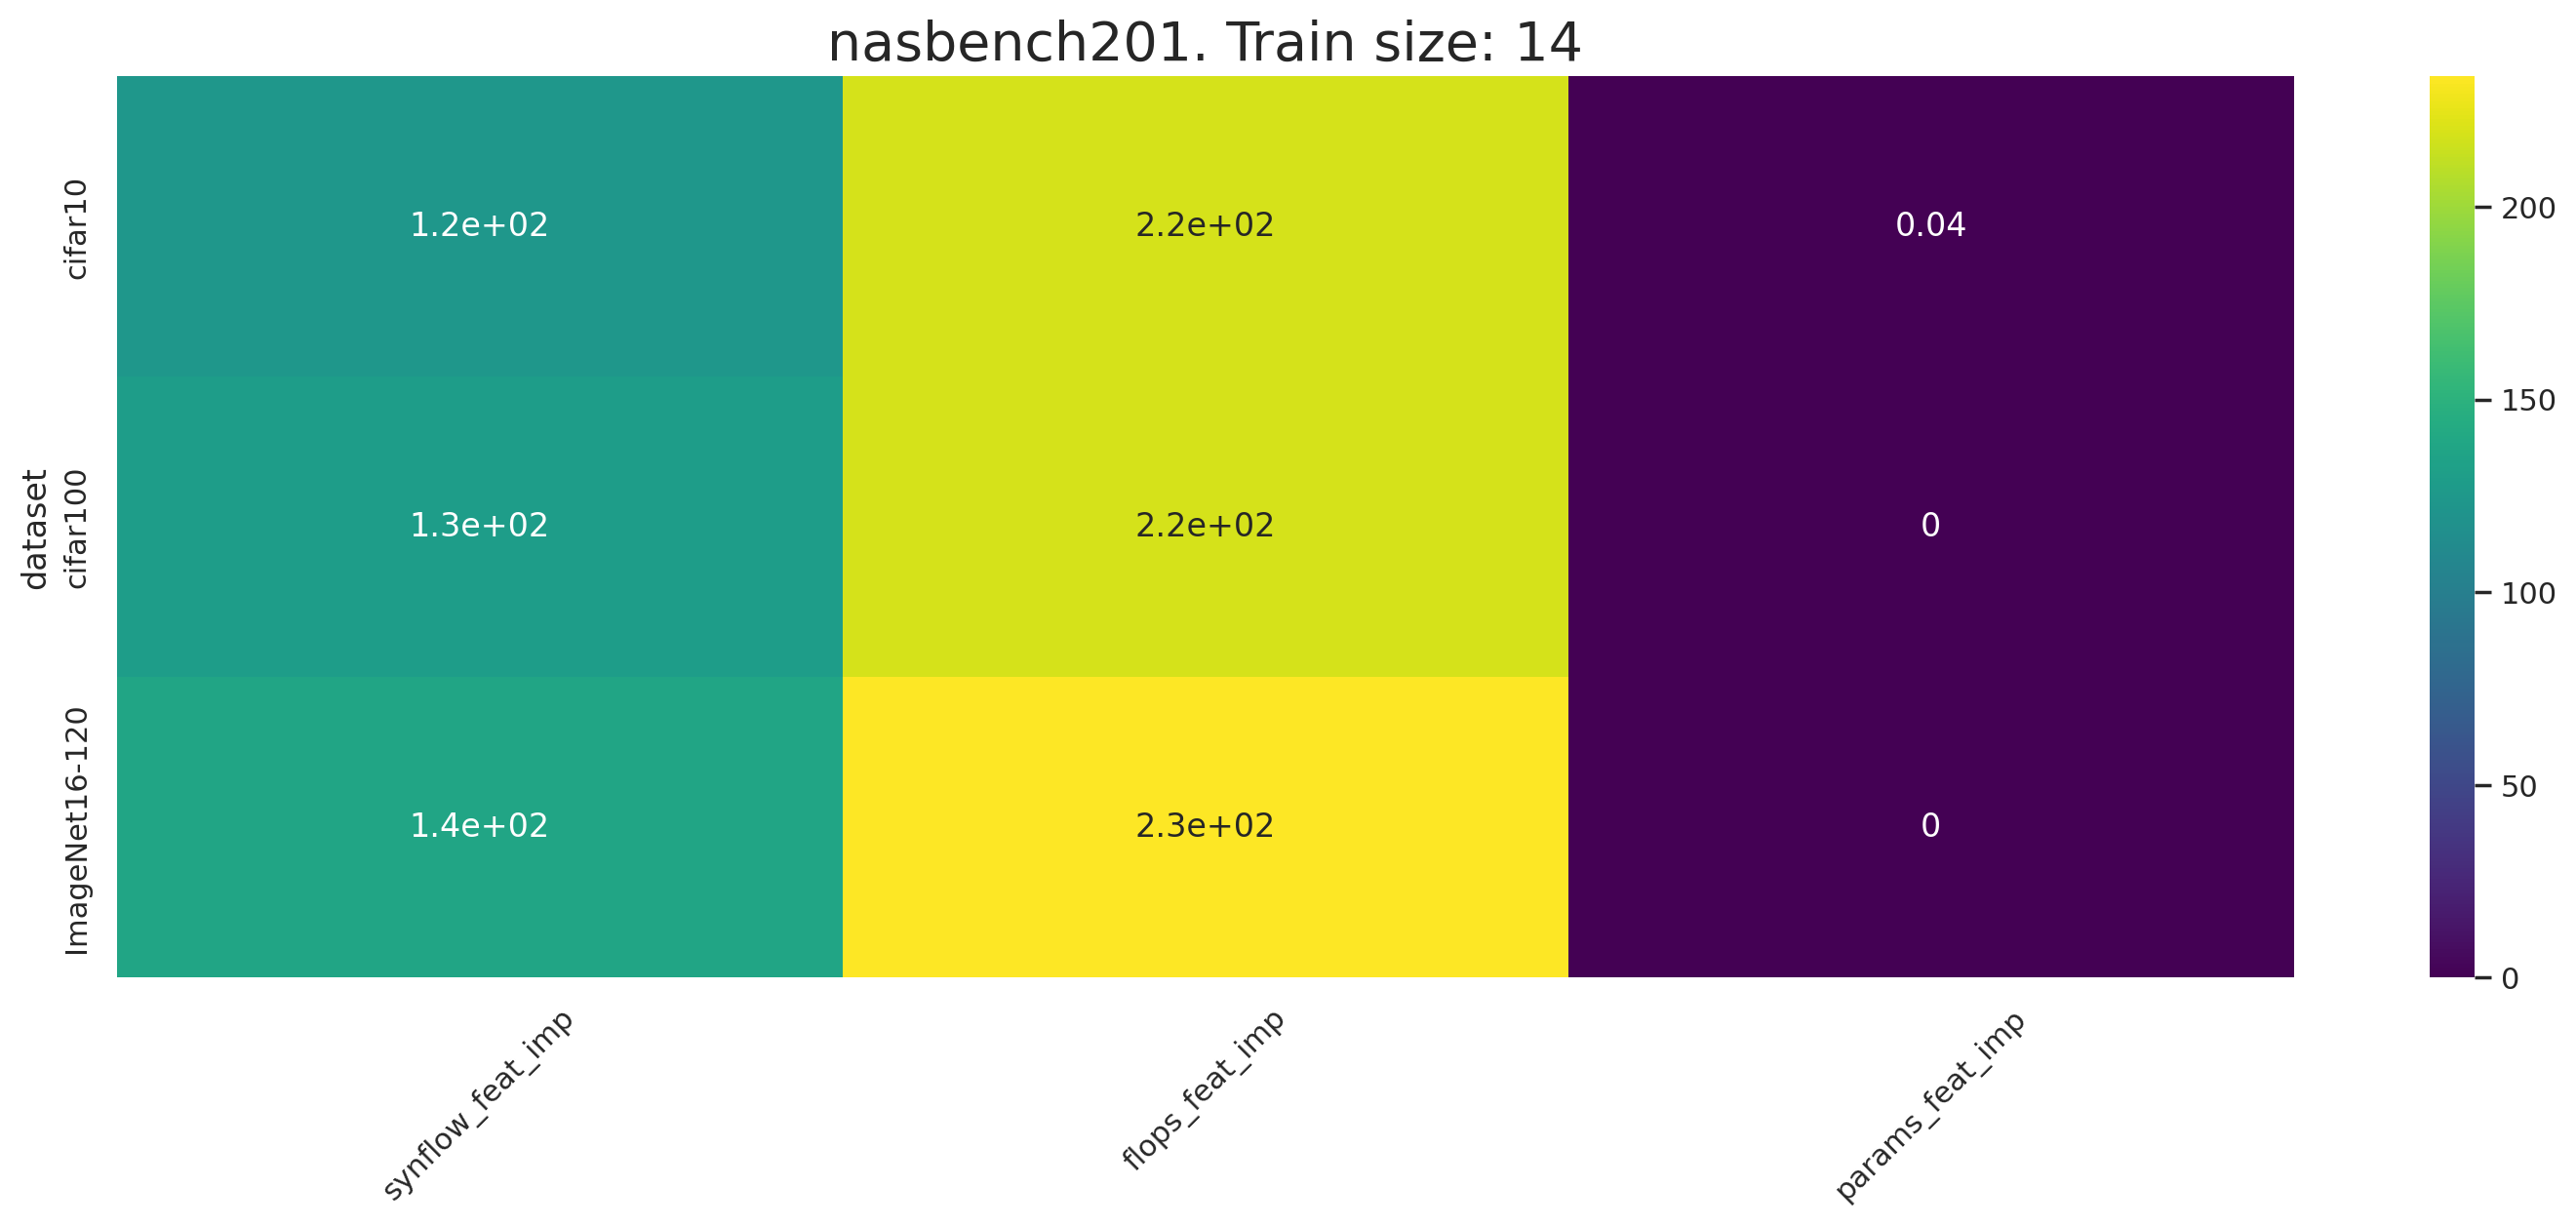

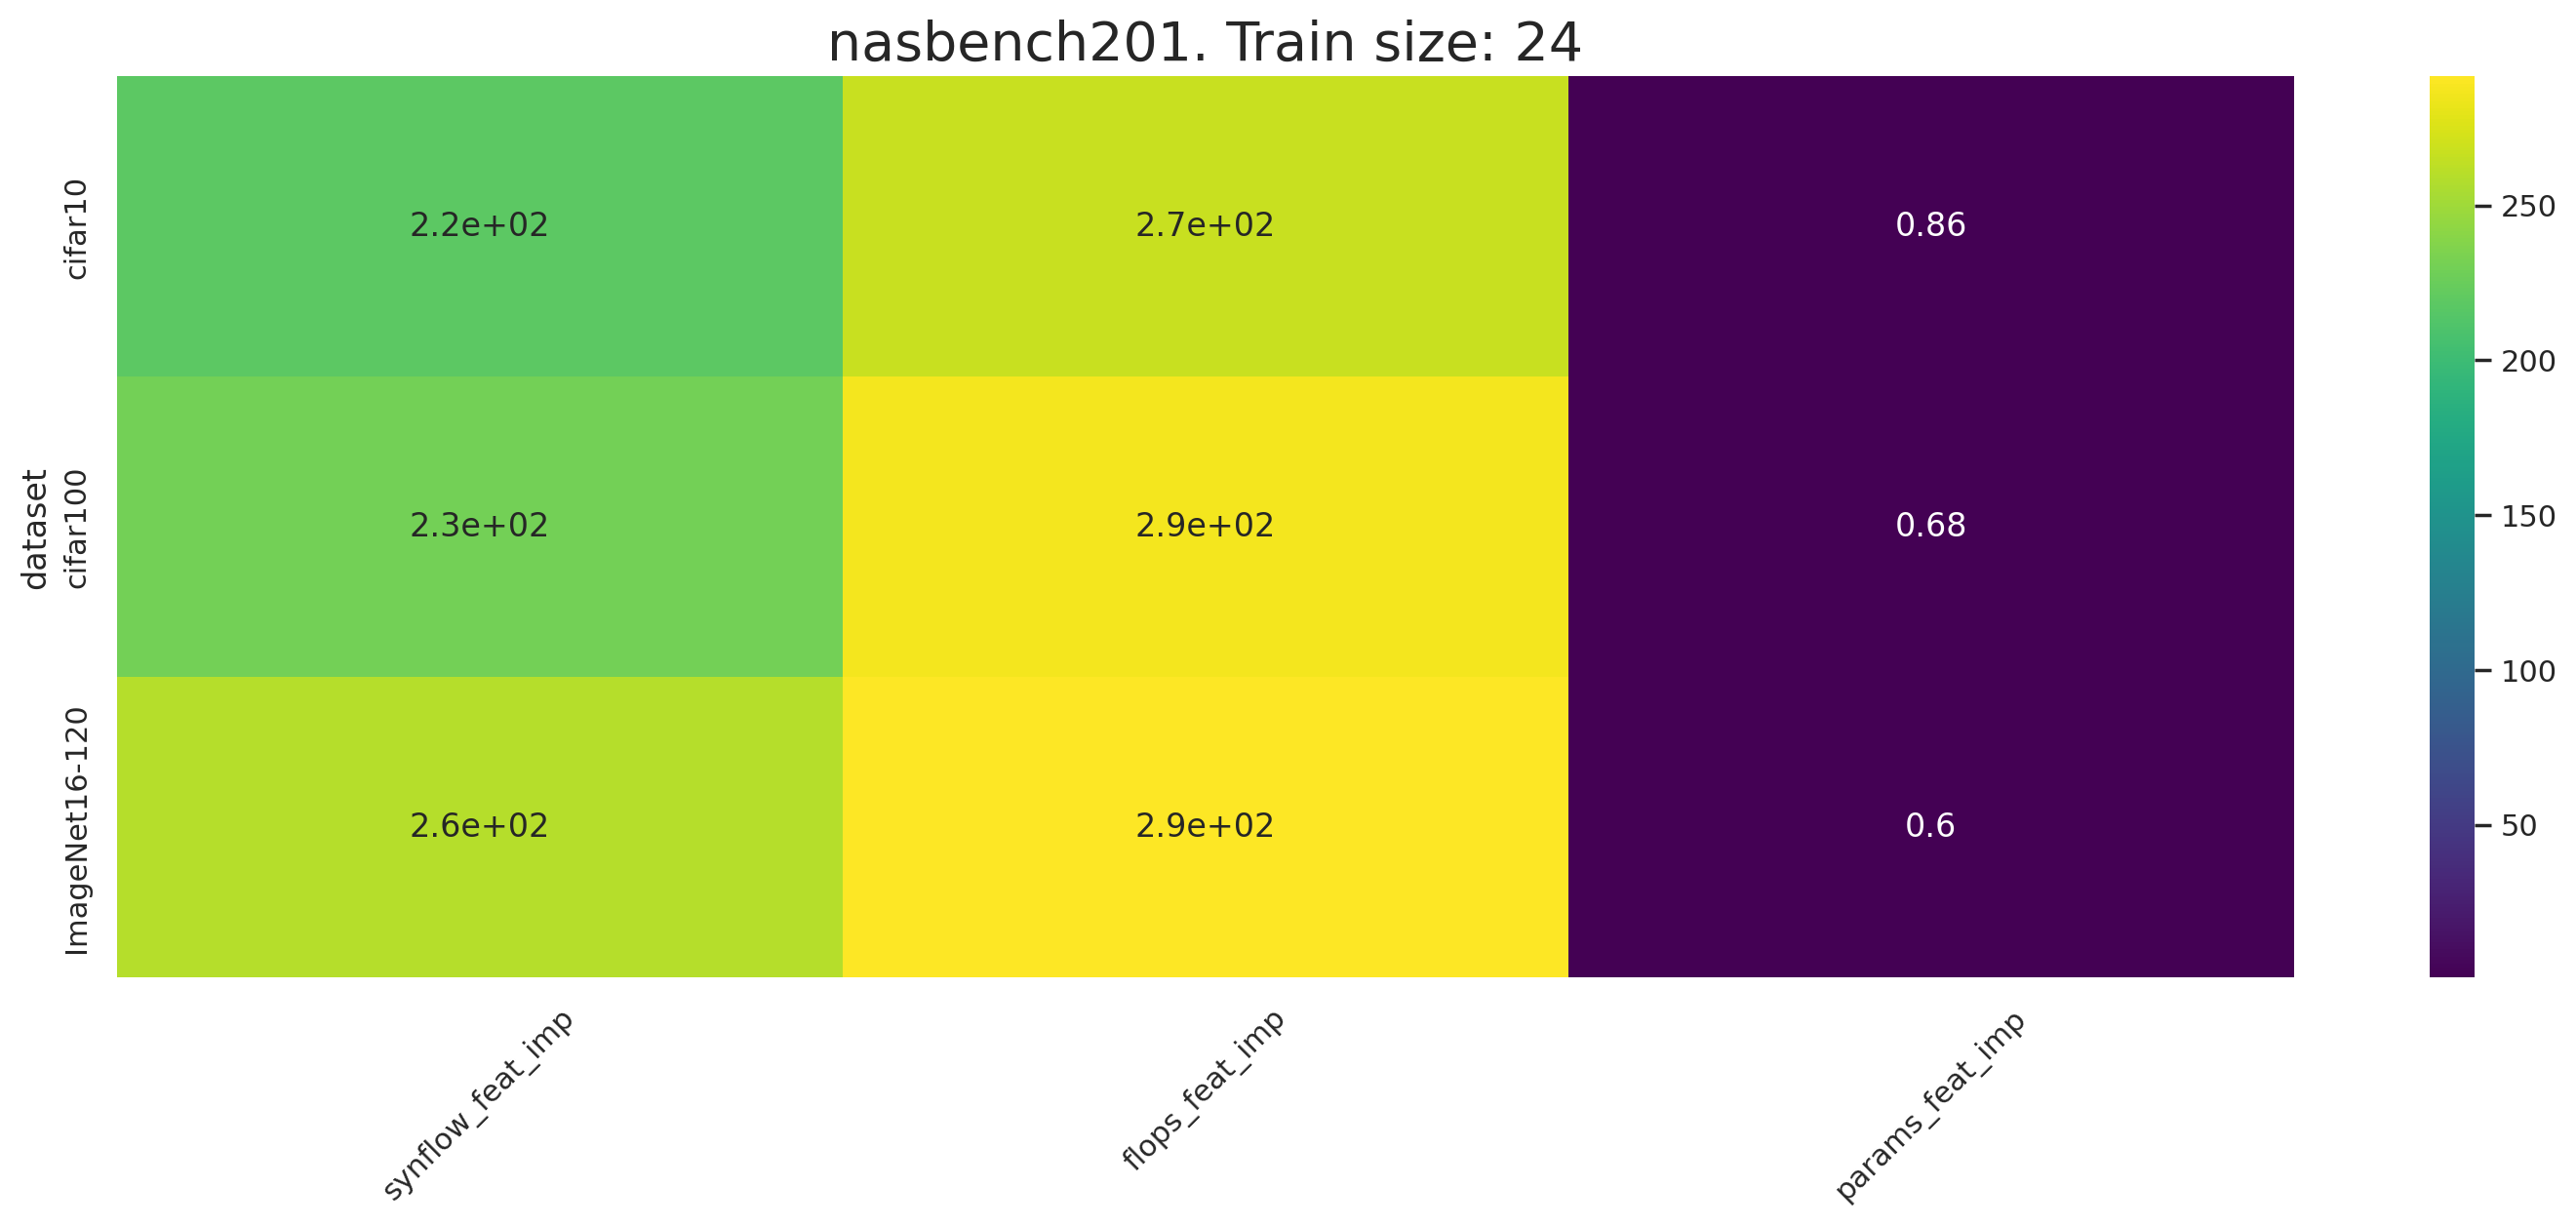

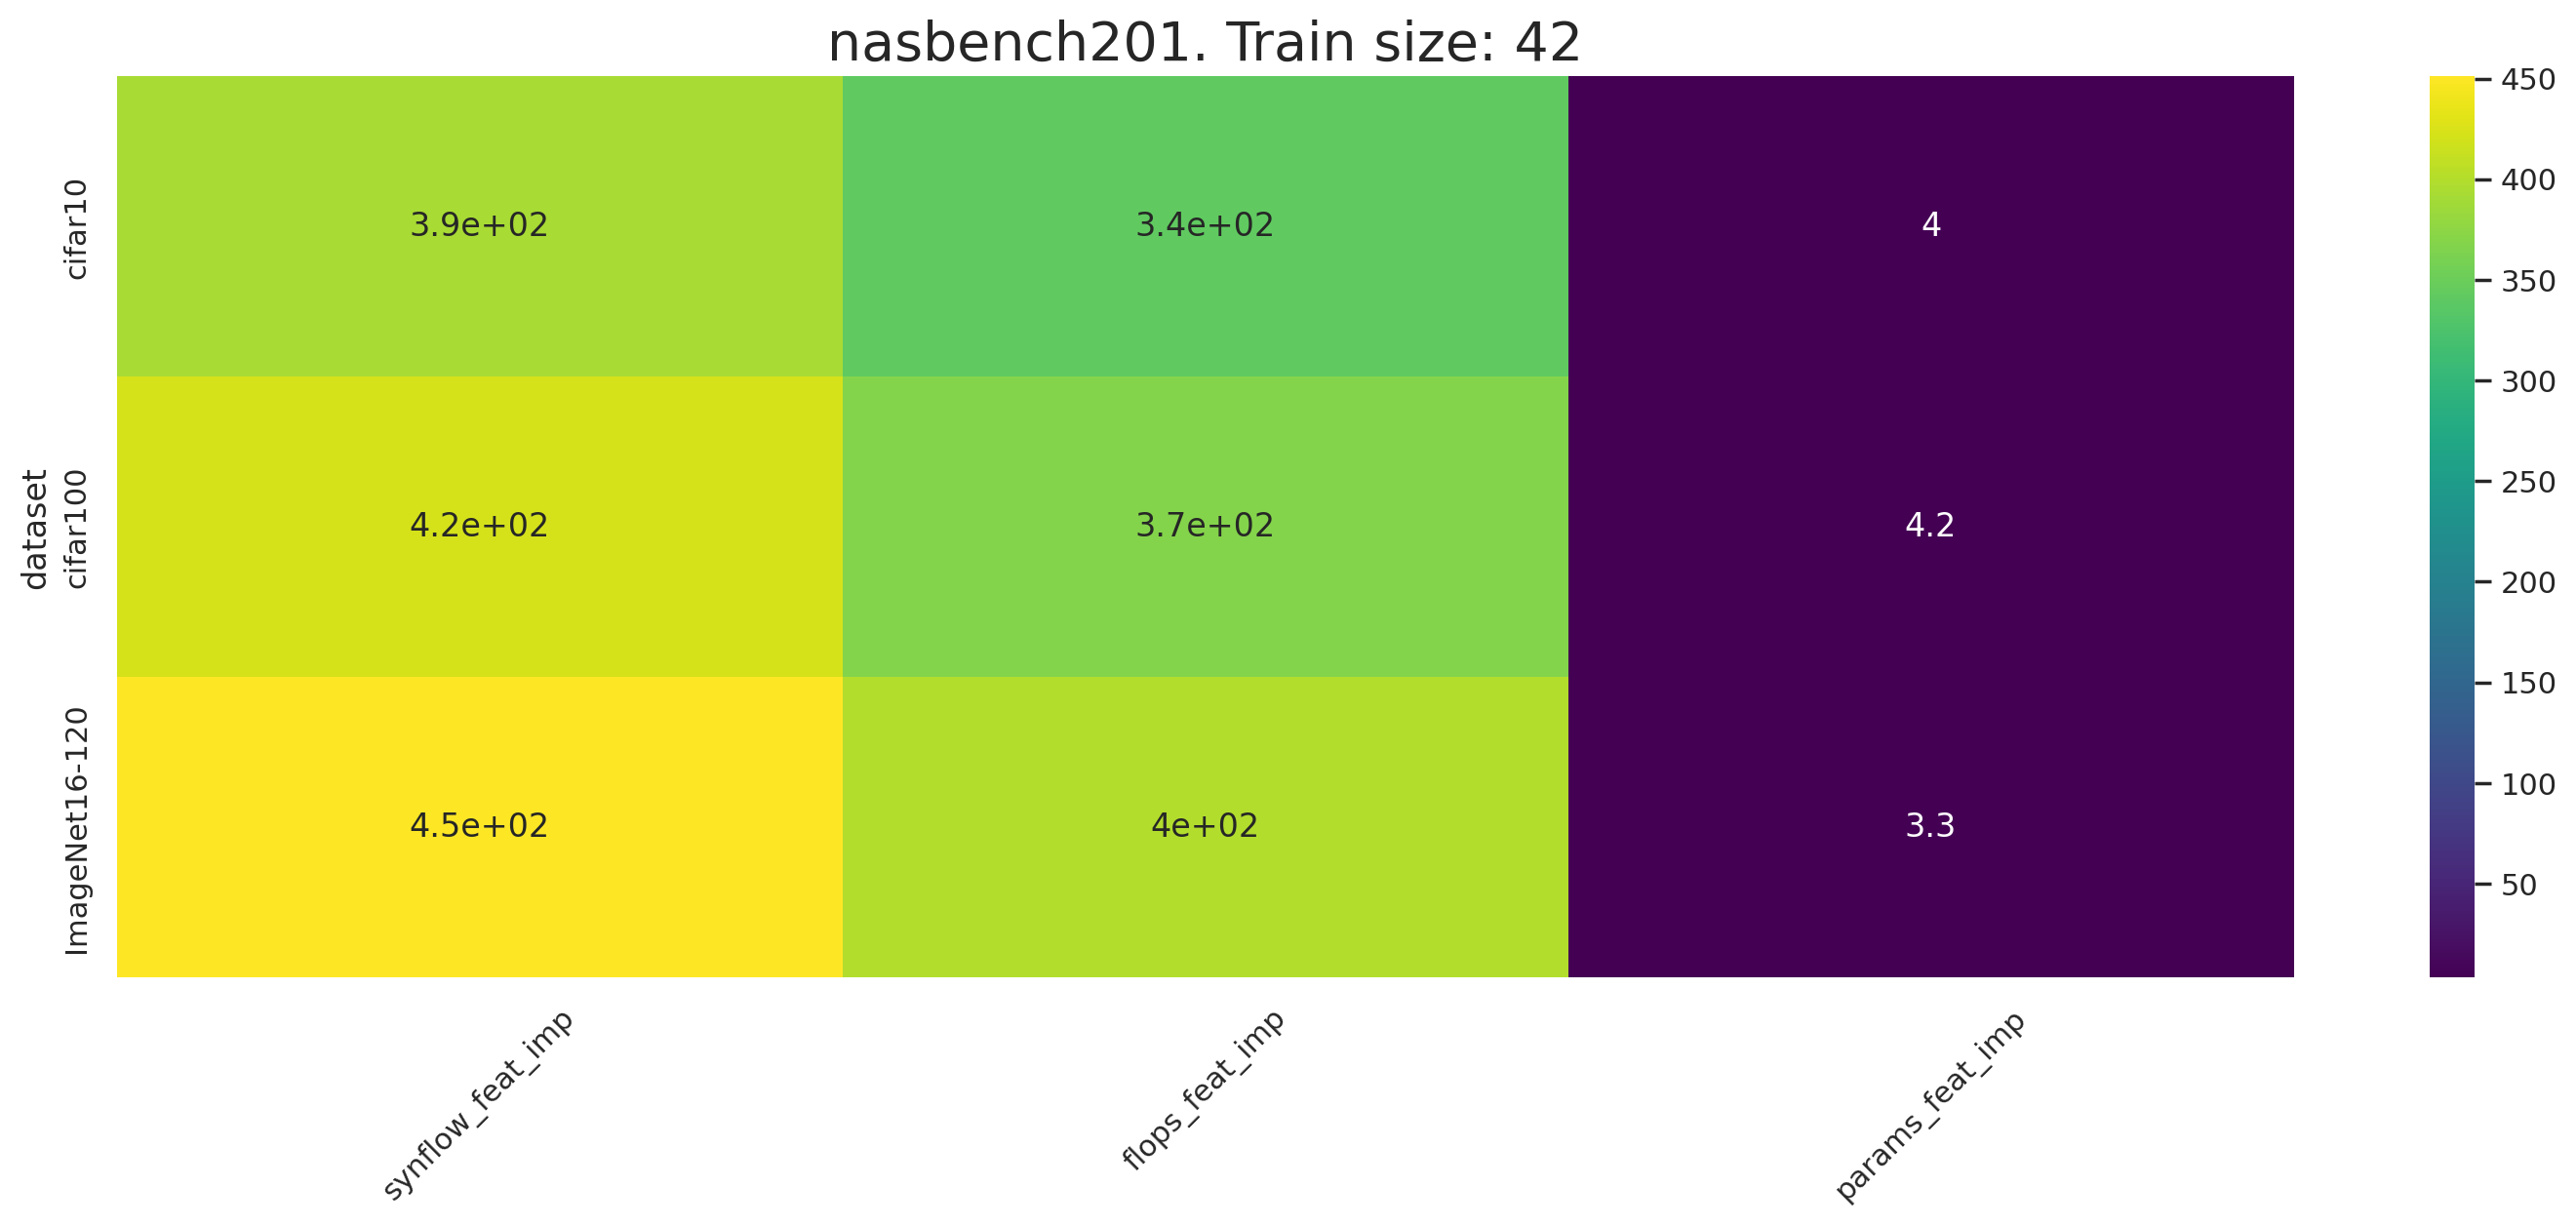

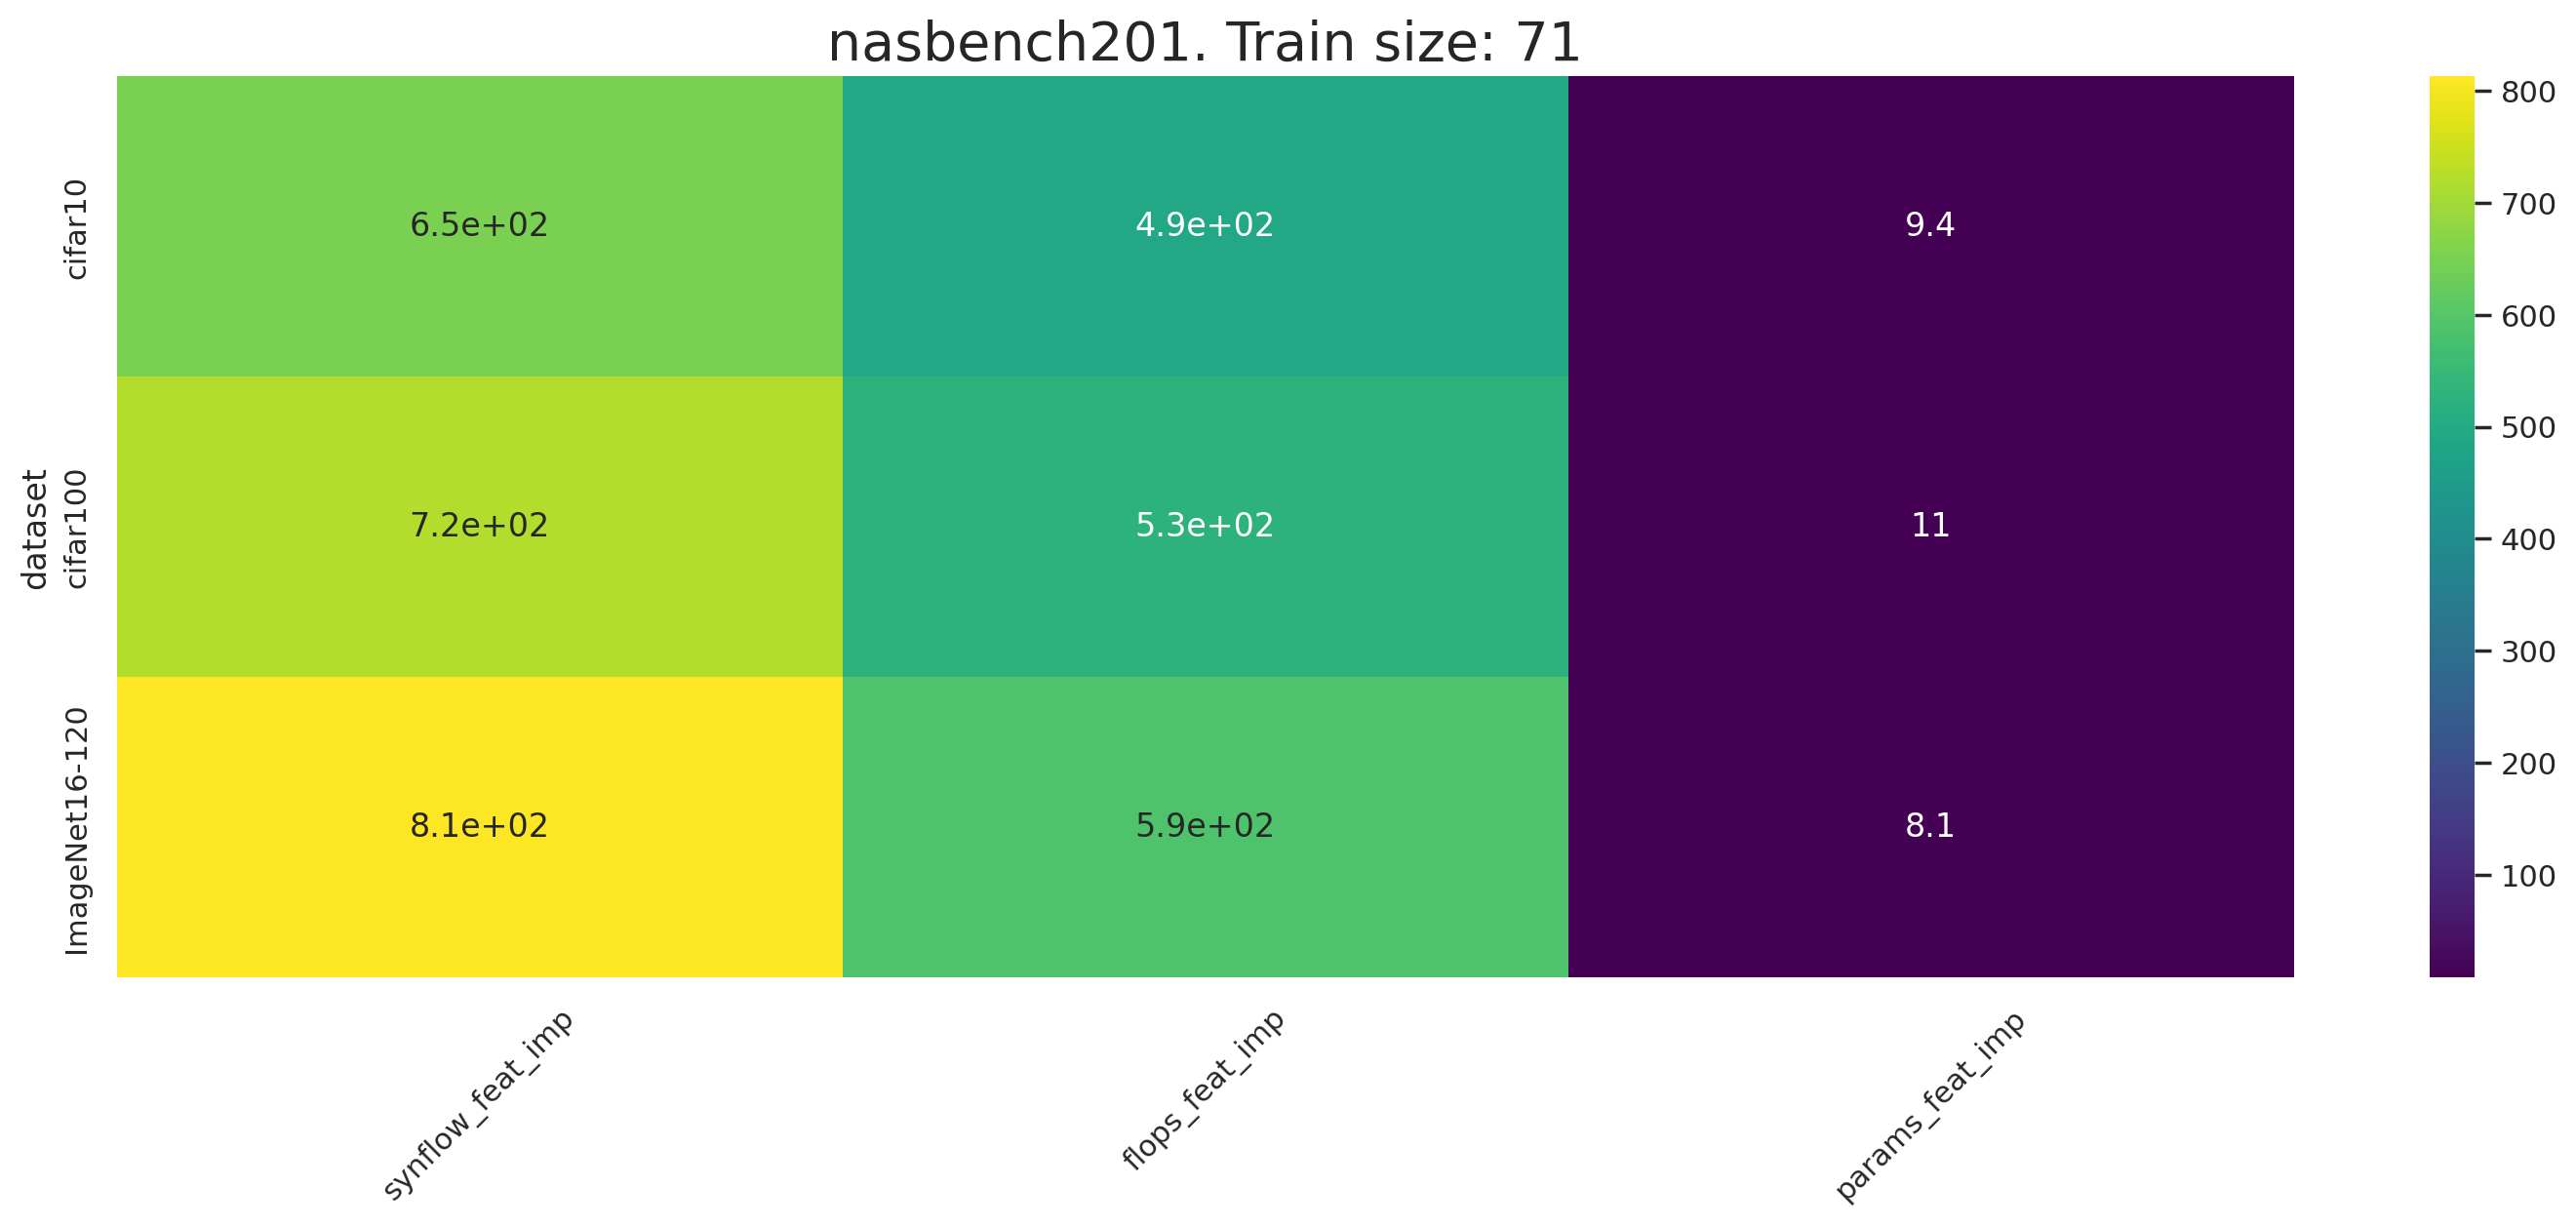

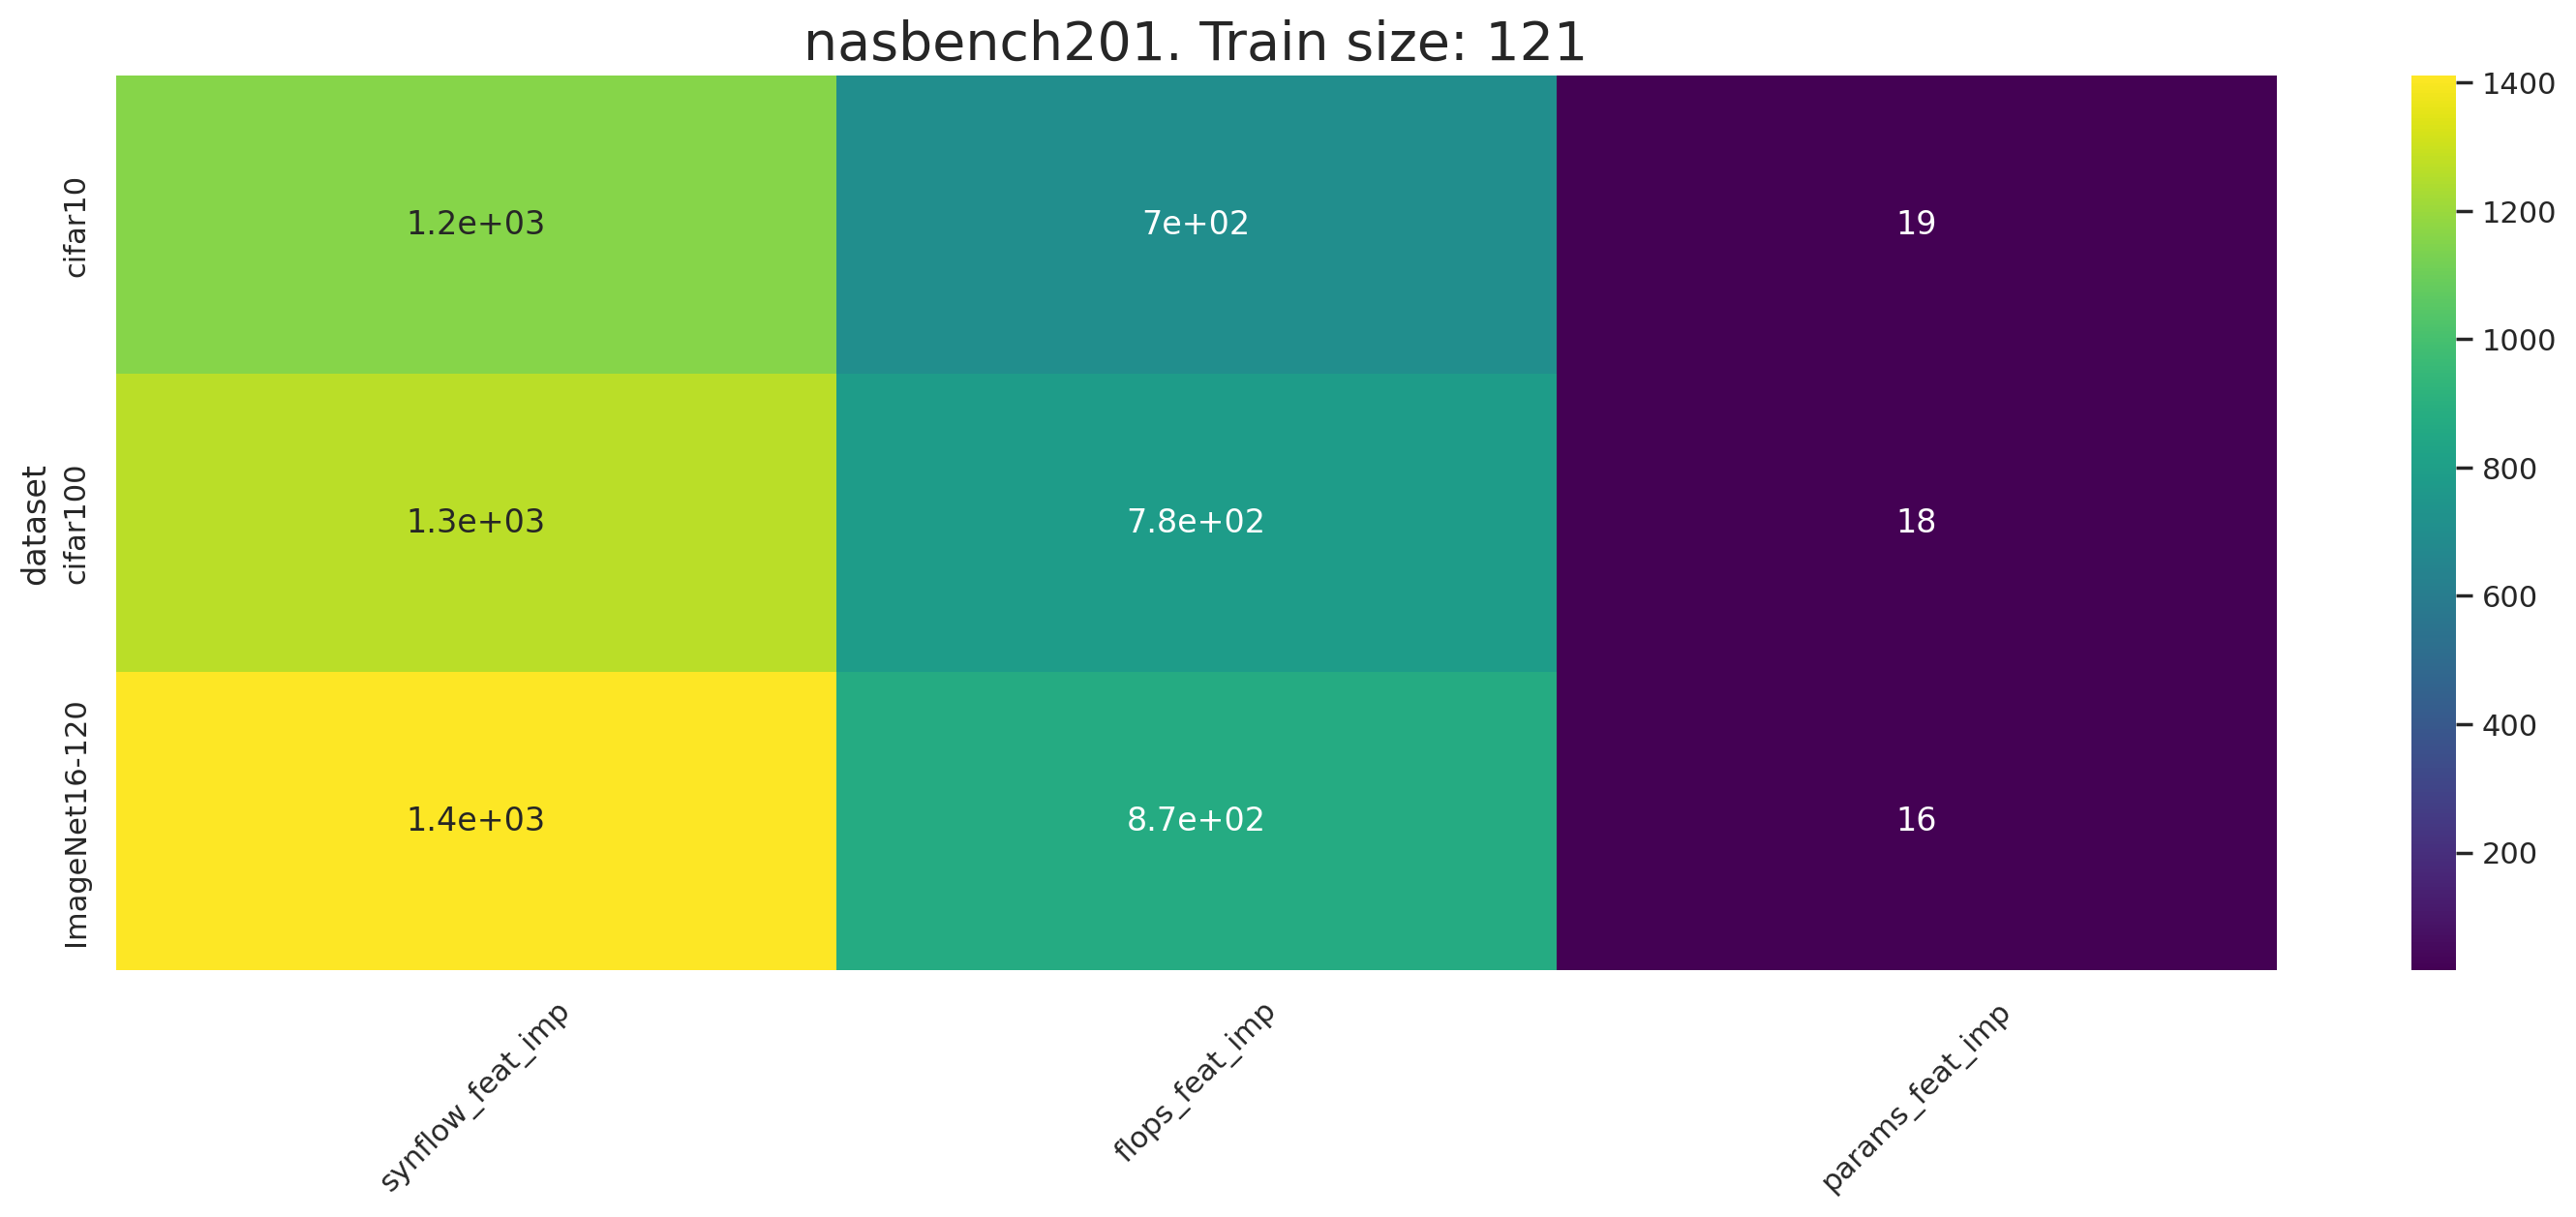

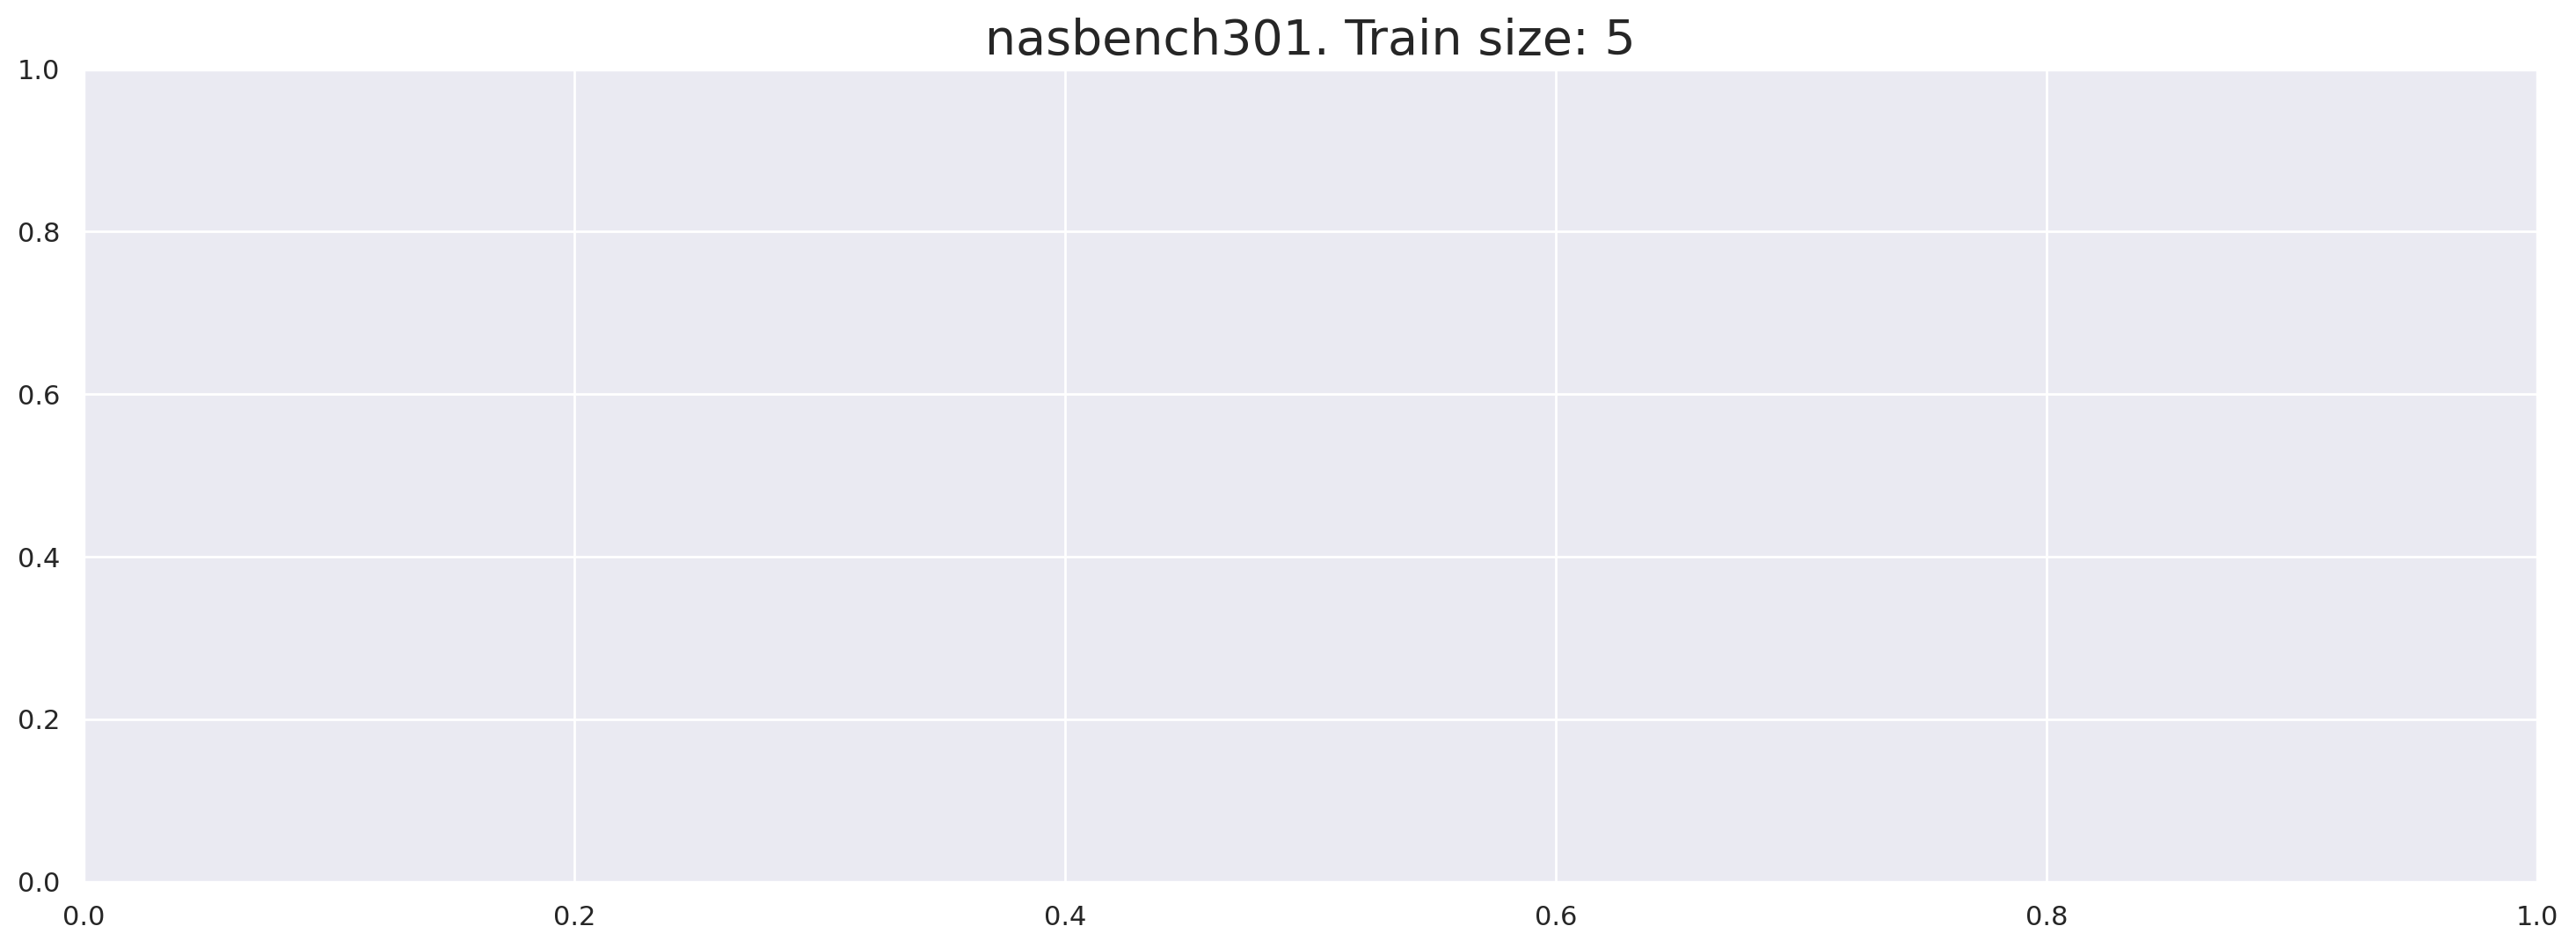

In [ ]:
for search_space in BENCHMARKS.keys():
    for train_size in train_sizes:
        plot_feature_importance_heatmap(df, search_space, train_size=train_size)


In [ ]:
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar10', train_sizes[:7], 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes[:7], 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes[:7], 'spearman', color='grey')